In [1]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 5

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data process (No need to run)

In [3]:
for root, dirs, files in os.walk('.'):
    for item in dirs:
        if (item[0]!='.'):
            try:
                os.remove(os.path.join(item,'.DS_Store'))
            except:
                pass

In [4]:
folders = os.listdir('extracted_images/')
for subfolder in folders:
    subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))     
    j = -1
    for image in subfolder_here:
        j+=1
        os.rename(os.path.join('extracted_images',subfolder,image), os.path.join('extracted_images',subfolder,subfolder+'_'+str(j)+'.jpg'))

In [ ]:
try:
    os.mkdir('mathsymbol')
except FileExistsError:
    pass
folders = os.listdir('extracted_images')
with open('msb.csv', mode='w') as msb:
    msb_writer = csv.writer(msb, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    msb_writer.writerow(['Filename', 'Class Label'])
    i = -1
    for subfolder in folders:
        i += 1
        subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))
        for image in subfolder_here:
            msb_writer.writerow([image,str(i)])

In [ ]:
for subfolder in folders:
    subfolder_here = os.listdir(os.path.join('extracted_images',subfolder))     
    for image in subfolder_here:
        shutil.copy(os.path.join('extracted_images',subfolder,image), os.path.join('mathsymbol',image) )

In [ ]:
def get_label(row):
    return int(row[1])

In [ ]:
f6 = open('msb.csv', encoding="utf-8")
reader6 = list(csv.reader(f6))
f6.close()
sorted(reader6[1:],key=get_label,reverse=True)[:5]

In [ ]:
import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))
for i in (1,2000,18000,43284):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

# Loading data

In [3]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [4]:
df_train = pd.read_csv('sample_data/sample_train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='sample_data/sample_train.csv',
                                 img_dir='sample_images/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128*2, #### CHANGE IF YOU LIKE 128*0.9
                          shuffle=True,
                          num_workers=4)


valid_dataset = QuickdrawDataset(csv_path='sample_data/sample_valid.csv',
                                 img_dir='sample_images/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128*2,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='sample_data/sample_test.csv',
                                img_dir='sample_images/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128*2,
                         shuffle=False,
                         num_workers=4)

Class distribution Train [ 117   46    8   24  103   98   49   14   12   56   10    2    3  185
  247   22 1383   22  171 1847   12  506  134  157  155   96    6   32
  114   35    3   27  160   77   75  146   45  810   19  743   21  141
  814   45   41]


In [5]:
#just check if data are loaded correctly
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 256
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 256
break minibatch for-loop


In [6]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [7]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost


# MODEL 1 4 CONVOLUTION AND 3 FULLY CONNECTED

Epoch: 001/005 | Batch 0000/0035 | Cost: 3.8136
Epoch: 001/005 | Train: 21.284%
Time elapsed: 5.64 min
Epoch: 002/005 | Batch 0000/0035 | Cost: 3.6299
Epoch: 002/005 | Train: 22.846%
Time elapsed: 11.28 min
Epoch: 003/005 | Batch 0000/0035 | Cost: 2.7468
Epoch: 003/005 | Train: 28.337%
Time elapsed: 16.96 min
Epoch: 004/005 | Batch 0000/0035 | Cost: 2.6224
Epoch: 004/005 | Train: 39.001%
Time elapsed: 22.58 min
Epoch: 005/005 | Batch 0000/0035 | Cost: 2.4777
Epoch: 005/005 | Train: 52.213%
Time elapsed: 28.25 min
Total Training Time: 28.25 min
Test accuracy: 51.30%
Total Time: 28.51 min


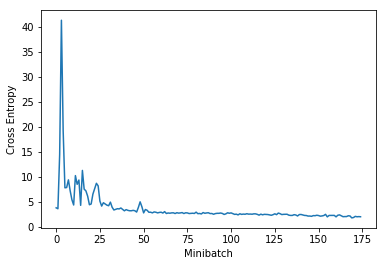

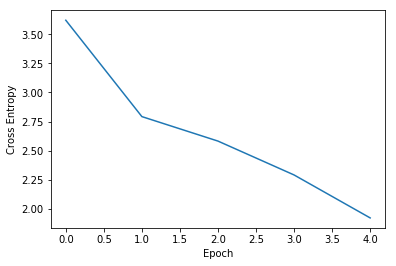

In [9]:
##########################
### MODEL
##########################

class ConvNet1(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet1, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 5 stride 2 ==>32*25*25 
        self.conv0 = nn.Conv2d(1, 32, kernel_size=5, stride=2,padding=4)#((25-1)*2+5-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        
        #32*25*25  kernel 5 stride 2 ==>64*15*15
        self.conv1 =  nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=4)#((15-1)*2+5-25)/2
        self.bn1=torch.nn.BatchNorm2d(64)
        
        #64*15*15  kernel 5 stride 2 ==>256*10*10
        self.conv2 = nn.Conv2d(64, 256, kernel_size=5,stride=2,padding=4)#((10-1)*2+5-15)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        
        #256*10*10  kernel 5 stride 2 ==>256*1*1
        self.conv3 = nn.Conv2d(256, 256, kernel_size=5,stride=10,padding=0)#((1-1)*2+5-10)/2
        self.bn3=torch.nn.BatchNorm2d(256)
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn4=torch.nn.BatchNorm2d(4096)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn5=torch.nn.BatchNorm2d(4096)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        out = self.conv0(x)
        
        #print(out.size())
        
        out = self.conv1(out)
        
        #print(out.size())
        
        out = self.conv2(out)
        
        out = self.conv3(out)
        
        out=out.view(out.size(0), -1)
        
        out = self.linear1(out)
        
        out = self.linear2(out)
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model1 = ConvNet1(NUM_CLASSES)
model1.to(DEVICE)

optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model1, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# MODEL 2 4 CONVOLUTION AND 3 FULLY CONNECTED

In [12]:
##########################
### MODEL
##########################

class ConvNet2(nn.Module):

    def __init__(se9lf, num_classes=NUM_CLASSES):
        super(ConvNet2, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 5 stride 3 ==>32*24*24
        self.conv0 = nn.Conv2d(1, 32, kernel_size=5, stride=2,padding=3)#((24-1)*2+5-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #32*24*24  kernel 5 stride 3 ==>64*12*12
        self.conv1 =  nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)#((12-1)*2+5-24)/2
        self.bn1=torch.nn.BatchNorm2d(64)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        #64*12*12  kernel 5 stride 3 ==>256*6*6
        self.conv2 = nn.Conv2d(64, 256, kernel_size=5,stride=2,padding=2)#((6-1)*2+5-12)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        
        #256*6*6  kernel 5 stride 3 ==>256*1*1
        self.conv3 = nn.Conv2d(256, 256, kernel_size=6,stride=6,padding=0)#((1-1)*2+6-6)/6
        self.bn3=torch.nn.BatchNorm2d(256)
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn4=torch.nn.BatchNorm2d(4096)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn5=torch.nn.BatchNorm2d(4096)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        
        #print(out.size())
        
        out = self.conv1(out)
        
        #print(out.size())
        
        out = self.conv2(out)
        
        #print(out.size())
        out = self.conv3(out)
        #print(out.size())
        out=out.view(out.size(0), -1)
        #print(out.size())
        out = self.linear1(out)
        #print(out.size())
        out = self.linear2(out)
        #print(out.size())
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model2 = ConvNet2(NUM_CLASSES)
model2.to(DEVICE)

optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model2, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

NameError: name 'self' is not defined

In [10]:
len(pd.read_csv("sample_data/sample_test.csv"))+len(pd.read_csv("sample_data/sample_train.csv"))+len(pd.read_csv("sample_data/sample_valid.csv"))

12269

# MODEL 3 3 CONVOLUTION AND 3 FULLY CONNECTED

Epoch: 001/005 | Batch 0000/0035 | Cost: 3.8149
Epoch: 001/005 | Train: 56.889%
Time elapsed: 2.40 min
Epoch: 002/005 | Batch 0000/0035 | Cost: 0.8194
Epoch: 002/005 | Train: 87.422%
Time elapsed: 5.29 min
Epoch: 003/005 | Batch 0000/0035 | Cost: 0.4156
Epoch: 003/005 | Train: 92.970%
Time elapsed: 7.69 min
Epoch: 004/005 | Batch 0000/0035 | Cost: 0.3274
Epoch: 004/005 | Train: 94.600%
Time elapsed: 9.70 min
Epoch: 005/005 | Batch 0000/0035 | Cost: 0.2955
Epoch: 005/005 | Train: 96.434%
Time elapsed: 11.59 min
Total Training Time: 11.59 min
Test accuracy: 89.73%
Total Time: 11.67 min


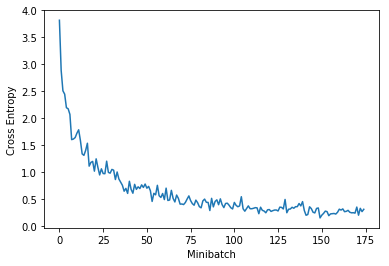

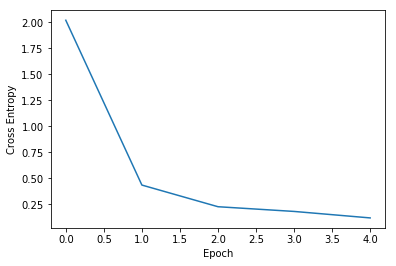

In [10]:
##########################
### MODEL
##########################

class ConvNet3(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet3, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 4 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=4,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*1*1
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=4, stride=3, padding=0)#((1-1)*3+4-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn3=torch.nn.BatchNorm1d(4096)
        self.drop3=torch.nn.Dropout(0.4)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn4=torch.nn.BatchNorm1d(4096)
        self.drop4=torch.nn.Dropout(0.4)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=self.drop0(out)
        out=F.relu(out)
        
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.drop1(out)
        out=F.relu(out)
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=self.drop2(out)
        out=F.relu(out)
        
        out=out.view(out.size(0), -1)
        
        
        out = self.linear1(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.drop3(out)
        
        
        
        out = self.linear2(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.drop4(out)
        
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model3 = ConvNet3(NUM_CLASSES)
model3.to(DEVICE)

optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model3, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# MODEL 4 3 CONVOLUTION AND 3 FULLY CONNECTED

In [4]:
##########################
### MODEL
##########################

class ConvNet4(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet4, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 5 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=5,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*1*1
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=4, stride=3, padding=0)#((1-1)*3+4-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn3=torch.nn.BatchNorm1d(4096)
        self.drop3=torch.nn.Dropout(0.4)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn4=torch.nn.BatchNorm1d(4096)
        self.drop4=torch.nn.Dropout(0.4)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=self.drop0(out)
        out=F.relu(out)
        
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.drop1(out)
        out=F.relu(out)
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=self.drop2(out)
        out=F.relu(out)
        
        out=out.view(out.size(0), -1)
        
        
        out = self.linear1(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.drop3(out)
        
        
        
        out = self.linear2(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.drop4(out)
        
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model4 = ConvNet4(NUM_CLASSES)
model4.to(DEVICE)

optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model4, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

NameError: name 'train' is not defined

In [5]:
class ConvNet4(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet4, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 5 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=5,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*1*1
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=4, stride=3, padding=0)#((1-1)*3+4-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn3=torch.nn.BatchNorm1d(4096)
        self.drop3=torch.nn.Dropout(0.4)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn4=torch.nn.BatchNorm1d(4096)
        self.drop4=torch.nn.Dropout(0.4)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=self.drop0(out)
        out=F.relu(out)
        
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.drop1(out)
        out=F.relu(out)
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=self.drop2(out)
        out=F.relu(out)
        
        out=out.view(out.size(0), -1)
        
        
        out = self.linear1(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.drop3(out)
        
        
        
        out = self.linear2(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.drop4(out)
        
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    

# Predict

In [5]:
folders = os.listdir('extracted_images')
class_match = dict()
i = -1
for subfolder in folders:
    i += 1
    class_match[i] = subfolder

True class: !


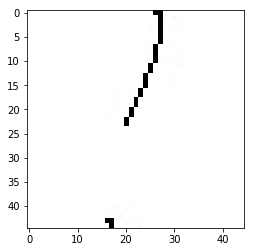

Predict class:  -


,Class,Probability
0,-,0.768514
1,+,0.056836
2,!,0.046700


In [9]:
application_index = [153]#<=153,354

import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))

with open('application.csv', mode='w') as app:
    app_writer = csv.writer(app, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    app_writer.writerow(['Filename', 'Class Label'])
    for image in application_index:
        app_writer.writerow([image_paths[image].split('/')[1], 0])
    
for i in application_index:
    im_path = image_paths[i]
    print('True class:', im_path.split('/')[1].split('_')[0])
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()
    
application_dataset = QuickdrawDataset(csv_path='application.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)
application_loader = DataLoader(dataset=application_dataset,
                          batch_size=1, 
                          shuffle=True,
                          num_workers=4)

def predict(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        probas_read = pd.Series(probas.tolist()[0])
        class_label = pd.Series(list(range(NUM_CLASSES)))
        top3 = []
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-1]])[0]], sorted(probas_read)[-1]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-2]])[0]], sorted(probas_read)[-2]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-3]])[0]], sorted(probas_read)[-3]]]
        top3 = pd.DataFrame(top3)
        _, predicted_labels = torch.max(probas, 1)
        print('Predict class: ', class_match[int(predicted_labels)])
        top3.columns = ['Class', 'Probability']
        return top3

predict(model, application_loader, DEVICE) 


# Save model



In [ ]:
model4.to(torch.device('cpu'))
torch.save(model4.state_dict(),'./my_model.pt')
#torch.save(optimizer.state_dict(),'/my_optimizer.pt')
#torch.save(scheduler.state_dict(),'/my_scheduler.pt')

# Reuse model

In [1]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 1

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class ConvNet4(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet4, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 5 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=5,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*1*1
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=4, stride=3, padding=0)#((1-1)*3+4-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn3=torch.nn.BatchNorm1d(4096)
        self.drop3=torch.nn.Dropout(0.4)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn4=torch.nn.BatchNorm1d(4096)
        self.drop4=torch.nn.Dropout(0.4)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=self.drop0(out)
        out=F.relu(out)
        
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.drop1(out)
        out=F.relu(out)
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=self.drop2(out)
        out=F.relu(out)
        
        out=out.view(out.size(0), -1)
        
        
        out = self.linear1(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.drop3(out)
        
        
        
        out = self.linear2(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.drop4(out)
        
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    

In [4]:
model=ConvNet4(NUM_CLASSES)
model.load_state_dict(torch.load('./my_model.pt'))
model=model.to(DEVICE)
#optimizer=torch.optim.SGD(model.paramter(),lr-0.1)
#optimzier.load_state_dict(torch.load('./my_optimizer.pt'))
#scheduler=torch.optim.lr_schedule.ExponentialLR(optimzer,gamma=0.1,last_epoch=-1)
#scheduler.load_state_dict(torch.load('./my_scheduler.pt'))
#model.train()

# Nin

In [21]:
class nin(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(nin, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 4 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=4,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.pool0=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.avgpool1=nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*2*2
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=2, stride=3, padding=0)#((2-1)*3+2-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.avgpool2=nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=F.relu(out)
        out=self.pool0(out)
        out=self.drop0(out)
        #print(out.size())
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.avgpool1(out)
        out=self.drop1(out)
        out=F.relu(out)
        #print(out.size())
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=F.relu(out)
        out=self.avgpool2(out)
        #print(out.size())
        
        out=out.view(out.size(0), -1)
        
        
        
        
        
        logits = out
        probas = F.softmax(logits, dim=1)
        return logits, probas

Epoch: 001/001 | Batch 0000/0035 | Cost: 5.5479
Epoch: 001/001 | Train: 21.239%
Time elapsed: 0.50 min
Total Training Time: 0.50 min
Test accuracy: 19.45%
Total Time: 0.51 min


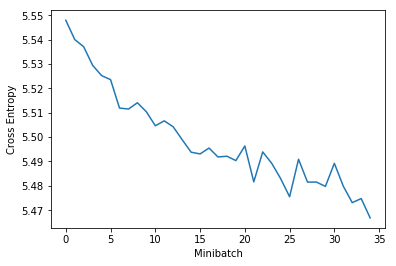

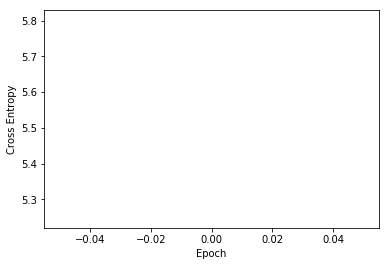

In [22]:
torch.manual_seed(RANDOM_SEED)


model = nin(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 


minibatch_cost, epoch_cost = train(model, train_loader, valid_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# Nin 2

In [38]:
class nin(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(nin, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 3 stride 2 ==>32*24*24
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=2,padding=2)#((24-1)*2+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.pool0=nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*24*24 kernel 3 stride 2 ==>32*12*12
        self.conv1 = nn.Conv2d(32, 32, kernel_size=4, stride=2,padding=1)#((12-1)*2+4-24)/2
        self.bn1=torch.nn.BatchNorm2d(32)
        self.pool1=nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #32*12*12 kernel 3 stride 2 ==>32*6*6
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2,padding=1)#((6-1)*2+4-12)/2
        self.bn2=torch.nn.BatchNorm2d(32)
        self.pool2=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        #32*6*6  kernel 3 stride 3 ==>256*4*4
        self.conv3 =  nn.Conv2d(32, 256, kernel_size=4, stride=3, padding=0)#((4-1)*3+4-12)/2
        self.bn3=torch.nn.BatchNorm2d(256)
        self.avgpool3=nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.drop3=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*2*2
        self.conv4 =  nn.Conv2d(256, 256, kernel_size=2, stride=3, padding=0)#((2-1)*3+2-4)/2
        self.bn4=torch.nn.BatchNorm2d(256)
        self.avgpool4=nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=F.relu(out)
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=F.relu(out)
        out=self.pool1(out)
        out=self.drop1(out)
        #print(out.size())
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=F.relu(out)
        #print(out.size())
        
        out = self.conv3(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.avgpool3(out)
        out=self.drop3(out)
        #print(out.size())
        
        out = self.conv4(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.avgpool4(out)
        #print(out.size())
        
        out=out.view(out.size(0), -1)
        
        
        
        
        
        logits = out
        probas = F.softmax(logits, dim=1)
        return logits, probas

Epoch: 001/005 | Batch 0000/0035 | Cost: 5.5449
Epoch: 001/005 | Train: 28.654%
Time elapsed: 1.18 min
Epoch: 002/005 | Batch 0000/0035 | Cost: 5.4006
Epoch: 002/005 | Train: 75.750%
Time elapsed: 2.48 min
Epoch: 003/005 | Batch 0000/0035 | Cost: 5.3453
Epoch: 003/005 | Train: 79.622%
Time elapsed: 4.12 min
Epoch: 004/005 | Batch 0000/0035 | Cost: 5.3041
Epoch: 004/005 | Train: 82.690%
Time elapsed: 5.53 min
Epoch: 005/005 | Batch 0000/0035 | Cost: 5.2748
Epoch: 005/005 | Train: 86.901%
Time elapsed: 6.81 min
Total Training Time: 6.81 min
Test accuracy: 83.20%
Total Time: 6.84 min


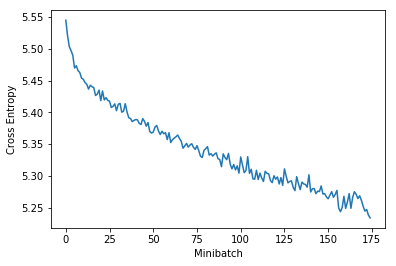

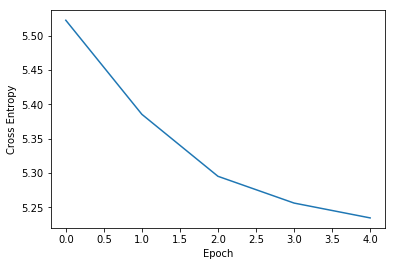

In [39]:
torch.manual_seed(RANDOM_SEED)


model = nin(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 


minibatch_cost, epoch_cost = train(model, train_loader, valid_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [40]:
model.to(torch.device('cpu'))
torch.save(model.state_dict(),'./sample_data_nin2.pt')